In [209]:
import numpy as np
import pandas as pd 
import altair as alt
import copy
import re 
import ntpath 
from commons import data_processing
from commons.DataProcessors import msfragger
from commons.APICallers import uniprot
from venn import venn

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [210]:
files = data_processing.get_files(r'./data/fractions/', exts=['psm.tsv'])

# use msfragger module to process data
msf = None
for file in files:
    m = msfragger.msf_processor([file])

#     # extract fraction and column info
    dirname = ntpath.dirname(file)
    spl = re.split(r'[\\\/]', dirname)
    column, fraction = spl[-2:]
    m.add_special_column('fraction', fraction)
    m.add_special_column('column', column)

    if msf is None:
        msf = m
    else:
        msf.join_processors(m)

# grab data
df = msf.data
msf

MSF Processor constructed on the following data:
./data/fractions/PGC\F1\psm.tsv
./data/fractions/PGC\F2\psm.tsv
./data/fractions/PGC\F3\psm.tsv
./data/fractions/PGC\F4\psm.tsv
./data/fractions/PGC\F5\psm.tsv
./data/fractions/PGC\F6\psm.tsv
./data/fractions/PGC\F7\psm.tsv
./data/fractions/PGC\F8\psm.tsv
./data/fractions/RPLC\F1\psm.tsv
./data/fractions/RPLC\F2\psm.tsv
./data/fractions/RPLC\F3\psm.tsv
./data/fractions/RPLC\F4\psm.tsv
./data/fractions/RPLC\F5\psm.tsv
./data/fractions/RPLC\F6\psm.tsv
./data/fractions/RPLC\F7\psm.tsv
./data/fractions/RPLC\F8\psm.tsv

In [211]:
no_mods = df[df.modified_peptide.isna()].index
df.loc[no_mods, "modified_peptide"] = df.loc[no_mods, "peptide"]
df.head(2)

,spectrum,spectrum_file,peptide,modified_peptide,prev_aa,next_aa,peptide_length,charge,retention,observed_mass,...,is_unique,protein,protein_id,entry_name,gene,protein_description,mapped_genes,mapped_proteins,fraction,column
0,20221109_GD_PGC_F1_run1.02562.02562.2,D:\MSFragger\20221109\MSFragger_PGC_Frations\F...,ATGAATPKK,ATGAATPKK,K,S,9,2,758.9805,843.4767,...,True,sp|P10412|H14_HUMAN,P10412,H14_HUMAN,HIST1H1E,Histone H1.4,NaN,NaN,F1,PGC
1,20221109_GD_PGC_F1_run1.02591.02591.2,D:\MSFragger\20221109\MSFragger_PGC_Frations\F...,ATTKPPPAK,ATTKPPPAK,K,K,9,2,768.1130,909.5245,...,True,sp|Q14978|NOLC1_HUMAN,Q14978,NOLC1_HUMAN,NOLC1,Nucleolar and coiled-body phosphoprotein 1,NaN,NaN,F1,PGC


In [212]:
avg = df.groupby(['column', 'fraction', 'modified_peptide', 'peptide']).mean()
avg.loc[:, 'retention_min'] = avg.retention/60

In [ ]:
column_colors = alt.Color('column:N',
    scale=alt.Scale(
        domain=["PGC", "RPLC"],
        range=["#D56E3B", "#58728C"]
    ))

axis_params = alt.Axis(
    labelFontSize=14,
    labelFontWeight=600,
    labelAngle=0,
    labelFlush=False
)

In [ ]:
mod_axis = axis_params.copy()
mod_axis["grid"] = False

id_density = alt.Chart(avg.reset_index(), height=40).mark_area(
    opacity=1,
    # stroke='lightgray',
    # strokeWidth=0.5
).transform_density(
    'retention_min',
    as_ = ['retention_min', 'density'],
    groupby=['fraction', 'column',]
).encode(
    x=alt.X('retention_min:Q', title='Retention Time (min)',
        axis=mod_axis),
    y=alt.Y('density:Q', 
        axis=mod_axis,
        scale=alt.Scale(range=[40, -5])),
    color=column_colors
).facet(
    row=alt.Row('fraction:N', title=None,
        header=alt.Header(labelAngle=0)),
    column=alt.Column('column:N', title=None)
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).properties(
    bounds='flush'
)

In [214]:
d = avg.reset_index()
# d = d.drop_duplicates(['modified_peptide', 'fraction'])

mod_axis = axis_params.copy()
mod_axis["ticks"] = False
mod_axis["labels"] = False

total = alt.Chart(d).mark_bar().encode(
    x=alt.X('column:N', title='', 
        axis=alt.Axis(labels=False, ticks=False)),
    y=alt.Y('distinct(modified_peptide)', title='Total Peptides',
        axis=axis_params),
    color=column_colors,
    column=alt.Column('fraction:N')
).properties(
    height=250,
    width=25
)

unique_frac = alt.Chart(d.drop_duplicates(['modified_peptide', 'fraction'], keep=False)).mark_bar().encode(
    x=alt.X('column:N', title='', 
        axis=mod_axis),
    y=alt.Y('distinct(modified_peptide)', title='Unique Peptides (fraction)'),
    color=column_colors,
    column=alt.Column('fraction:N')
).properties(
    height=250,
    width=25
)

unique = alt.Chart(d.drop_duplicates(['modified_peptide'], keep=False)).mark_bar().encode(
    x=alt.X('column:N', title='', 
        axis=mod_axis),
    y=alt.Y('distinct(modified_peptide)', title='Unique Peptides',
        axis=axis_params),
    color=column_colors,
    column=alt.Column('fraction:N')
).properties(
    height=250,
    width=25
)

# total | unique_frac | unique
# total | unique

<AxesSubplot:>

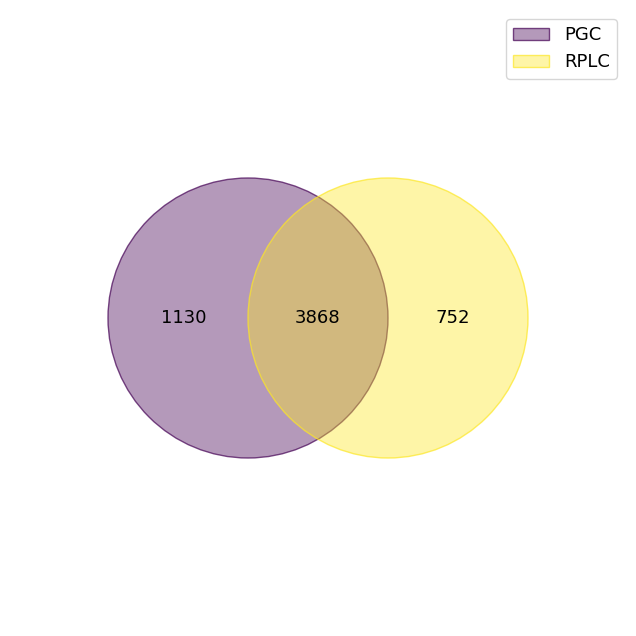

In [220]:
v = df.groupby(['column', 'protein_id'], as_index=False).count()
overlap = {}
for column in v.column.unique():
    small = v[v.column==column]
    overlap[column] = set(small.protein_id.tolist())
venn(overlap)

In [ ]:
prot1 = df.groupby(['column', 'fraction', 'protein_id'], as_index=False).mean()
prot2 = prot1.drop_duplicates('protein_id', keep=False)


base = alt.Chart(prot2).encode(
    x=alt.X('fraction:N', title='Fraction',
        axis=axis_params),
    y=alt.Y('distinct(protein_id):Q', title='Unique Proteins',
        axis=axis_params),
    color=column_colors,
    # column=alt.Column('fraction:N')
).properties(
    height=150,
    width=400
)

line = base.mark_line(
    opacity=0.6,
    strokeWidth=3,
    strokeDash=[5, 3],
)

dots = base.mark_circle(size=75)

# line + dots

In [ ]:
from modlamp.descriptors import PeptideDescriptor

def pour(seq):
    desc = PeptideDescriptor(seq, 'gravy')
    desc.calculate_global()
    return desc.descriptor[0][0]

df.loc[:, 'gravy'] = df.peptide.map(pour)
avg = df.groupby(['column', 'modified_peptide', 'peptide']).mean()
avg.loc[:, 'retention_min'] = avg.retention/60

In [ ]:
d = avg.reset_index()
# d.drop_duplicates('modified_peptide', inplace=True)
mod_x_axis = axis_params.copy()
mod_x_axis["tickMinStep"] = 10
base = alt.Chart(d).encode(
    x=alt.X('retention_min:Q', title='Retention Time (min)',
        axis=mod_x_axis,
        bin=alt.Bin(
            step=5
        )),
    y=alt.Y('mean(gravy):Q', title='GRAVY',
        axis=axis_params,),
    color=column_colors
)

line = base.mark_line(interpolate='basis') 
band = base.mark_errorband(extent='ci', interpolate='basis')

# line + band

In [ ]:
d = avg.reset_index()
d.drop_duplicates('modified_peptide', inplace=True, keep=False)
alt.Chart(d).mark_boxplot().encode(
    x='column:N',
    y='peptide_length:Q'
)

# import seaborn as sns 
# sns.violinplot(x='column', y='peptide_length', data=d)

x_axis = axis_params.copy()
x_axis["labels"] = False
x_axis["ticks"] = False
x_axis["grid"] = False

alt.Chart(d, width=100).mark_circle(
    size=8,
    opacity=0.2
).encode(
    x=alt.X('jitter:Q', title='',
        axis=x_axis),
    y=alt.Y('peptide_length:Q', title='Peptide Length',
        axis=axis_params),
    column=alt.Column('column:N'),
    color=column_colors
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

In [ ]:
# import seaborn as sns 
# sns.violinplot(x='column', y='peptide_length', data=d)
alt.Chart(d, width=100).mark_boxplot(opacity=0.5, size=50).encode(
    # x='column:N',
    y=alt.Y('peptide_length:Q', title='Peptie Length',
        axis=axis_params),
    column=alt.Column('column:N'),
    color=column_colors
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

In [ ]:
from importlib import reload 
reload(uniprot)
accs = df.protein_id.unique()
print(len(accs))
loc_map = {}
for i in range(0, len(accs)+1000, 100):
    sent = accs[i:i+100]
    call = uniprot.send_accessions(sent)
    resp = uniprot.parse_response(call, wanted_value='sc_location')
    loc_map.update(resp)

df.loc[:, 'sub_location'] = df.protein_id.map(loc_map)


In [ ]:
df.loc[:, 'sub_location'] = df.protein_id.map(loc_map)
df.loc[(~df.sub_location.isna()), 'sub_location'] = df.loc[(~df.sub_location.isna()), 'sub_location'].map(lambda x: x.split(',')[0])

In [ ]:
# reduced = df.drop_duplicates('modified_peptide', keep=False)
# reduced = reduced.groupby(['column', 'sub_location', 'protein_id'], as_index=False).count()
# reduced = reduced.iloc[:, :3].groupby(['column', 'sub_location'], as_index=False).count()
# reduced = reduced[reduced.protein_id>=25]
# # pgc_comp_count = reduced[reduced.column=='PGC'].iloc[:, :3]
# # rplc_comp_count = reduced[reduced.column=='RPLC'].iloc[:, :3]

# alt.Chart(reduced).mark_arc().encode(
#     # x=alt.X('column:N'),
#     theta=alt.Theta('protein_id:Q'),
#     color=column_colors,
#     facet=alt.Facet('sub_location:N', columns=5)
# ).resolve_scale(
#     theta='independent'
# ).properties(
#     width=75,
#     height=75
# )


In [ ]:
# reduced = df.drop_duplicates(['sub_location', 'protein_id'], keep=False)
# reduced = reduced.groupby(['column', 'sub_location', 'protein_id'], as_index=False).count()
# reduced = reduced.groupby(['column', 'sub_location'], as_index=False).count()

# valid = reduced.groupby('sub_location', as_index=False).sum()
# valid = valid[valid.protein_id >= 5]

# reduced = reduced[reduced.sub_location.isin(valid.sub_location)]

# alt.Chart(reduced).mark_arc().encode(
#     # x=alt.X('column:N'),
#     theta=alt.Theta('protein_id:Q'),
#     color=column_colors,
#     facet=alt.Facet('sub_location:N', columns=3)
# ).resolve_scale(
#     theta='independent'
# ).properties(
#     width=100,
#     height=100
# ).configure_view(
#     strokeWidth=0
# )

In [ ]:
reduced = df.groupby(['column', 'sub_location', 'protein_id'], as_index=False).count()
reduced = reduced.set_index(['sub_location'])

location_overlap = pd.DataFrame()

for location in df.sub_location.dropna().unique():
    print(location)
    small = reduced.loc[location, :]
    if isinstance(small, pd.Series):
        print('SERIES')
        continue
    s = small.iloc[:, :2].groupby(['column', 'protein_id'], as_index=[True, False]).count()
    s = s.reset_index('protein_id')
    look = {key: set(s[s.index==key].protein_id.to_list()) for key in s.index}
    for k in ["PGC", "RPLC"]:
        look[k] = look.get(k, set())
    pgc = look["PGC"] - look["RPLC"] 
    rplc = look["RPLC"] - look["PGC"]
    both = look["PGC"] & look["RPLC"]

    data = pd.DataFrame({
        'sub_location':location,
        'kind':['PGC', 'RPLC', 'Both'],
        'values':[len(pgc), len(rplc), len(both)]
    })

    location_overlap = pd.concat([location_overlap, data])
    location_overlap.reset_index(inplace=True, drop=True)
location_overlap

In [ ]:
p = location_overlap[location_overlap.kind=="PGC"]
r = location_overlap[location_overlap.kind=="RPLC"]

m = p.merge(r, left_on='sub_location', right_on='sub_location')
valid = m[(m.values_x>=m.values_y) & (m.values_x>10)]

l = location_overlap[location_overlap.sub_location.isin(valid.sub_location)]

base = alt.Chart(l).encode(
    # x=alt.X('column:N'),
    theta=alt.Theta('values:Q'),
    color=alt.Color('kind:N',
        scale=alt.Scale(
        domain=["PGC", "RPLC", "Both"],
        range=["#D56E3B", "#58728C", "#AAAAAA"]
        )),
).properties(
    width=100,
    height=100
)

pie = base.mark_arc()
text = base.mark_text(radiusOffset=10000).encode(text="values:Q")

alt.layer(pie, text).facet(
    column='sub_location:N'
).resolve_scale(
    theta='independent'
).configure_view(
    strokeWidth=0
)

In [ ]:
df.columns